# Week 8 worksheet: Numerical solution of hyperbolic PDEs

$$\newcommand{\vect}[1]{\bm #1}
\newcommand{\grad}{\nabla}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\pdderiv}[2]{\frac{\partial^2 #1}{\partial #2^2}}
\newcommand{\deriv}[2]{\frac{\mathrm{d} #1}{\mathrm{d} #2}}
\newcommand{\Deriv}[3]{\frac{\mathrm{d}^#3 #1}{\mathrm{d} #2^#3}}$$

In this laboratory we will look at hyperbolic problems, solving the one dimensional, linear advection equation
$$\pderiv{u}{t}+a\pderiv{u}{x}=0,$$
where $u$ is a scalar quantity being advected at a uniform speed, $a$, over a periodic domain, $x\in[0,1]$.

The initial conditions are 
$$u(x,0) = \begin{cases}
\sin^4 2\pi x & 0 \le x \le \frac12 \\
1 & \frac46 \le x \le \frac56 \\
0 & \text{otherwise}
\end{cases}$$

If the advection speed is an integer then every second the wave form will be back at the starting position.  This means we can make a direct comparison between the initial conditions and the results from the solver.

Your are going to develop a simple one dimensional solver using Python to solve the problem.  In this question you are going to write the key parts of the driver routines needed to create a grid, calculate the time step, set up the initial conditions, solve the equations using the first order upwind scheme and plot the results.  The code starts with the following imports and definitions:


In [4]:
import numpy as np
from matplotlib import pyplot as plt

N = 500 # Number of grid points being used
AdvectionSpeed = 1.0 # Advection speed (celarity) of the wave
CourantNumber = 0.95 # Courant number

In [5]:
%run scripts/create_widgets.py W07

<IPython.core.display.Javascript object>

Buttons created!


*How it works: You will see cells located below each exercise, each containing a command starting with `%run scripts/show_solutions.py`. You don't need to run those yourself; the command above runs a script which automatically runs these specific cells for you. The commands in each of these cells each create the button for the corresponding exercise. The Python code to achieve this is contained in `scripts/show_solutions.py`, and relies on [IPython widgets](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html) --- feel free to take a look at the code if you are curious.*

In [6]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Exercise 1 - Grid generation

### Part a)
This  function _GridGen(N)_ which creates an array $x$ which contains a uniformly spaced grid of $N$ grid points over the interval $[0,1]$.  The function must return both the mesh spacing $\Delta x$ and the $N$ ordinates $x_i$.

The following code generates a simple 1D grid and returns the mesh spacing, $\Delta x$

In [7]:
def GridGen(N):
    ''' generate a 1D grid from over [0.0,1.0] with N grid points.'''
    x_ord = np.linspace(0.0, 1.0 ,N)
    dx = x_ord[1]-x_ord[0]
    
    return dx, x_ord

We now write a function _InitialConditions(c)_ which returns an array $u$  so that
$$u = \begin{cases}
\sin^4 2\pi x & 0 \le x \le \frac12 \\
1 & \frac46 \le x \le \frac56 \\
0 & \text{otherwise}
\end{cases}$$


In [16]:
def InitialConditions(x_ord):
    ''' set up the intial conditions so that u(x)=sin^4(2 Pi x) for x
    in [0.0,0.5] and u(x) = 1 for x in [4/6,5/6] and u(x)=0
    otherwise.  These are the initial conditions for the classical
    test problem.'''
    
    # initialise everythging to zero
    u = np.zeros(N)

    # set up the Gaussian wave
    for i in range(N//2):
        u[i]=np.sin(x_ord[i]*np.pi*2)**4

    # and the top hat
    n0 = 4*N//6
    n1 = 5*N//6+1
    u[n0:n1] = 1.0

    return u


In [17]:
%run scripts/show_solutions.py W08_ex1_partb

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border_bottom='1px solid green', border_left='1px solid green', border_right='1px solid g…

Write a function _TimeStep($\Delta x$)_ which computes the stable time step, $$\Delta t = \nu \frac{\Delta x}{|a|}$$ where $\nu$ is the Courant number, and $a$ is the advection speed.  Remember that the advection speed, $a$, is given by the Python constant <code>AdvectionSpeed</code> and the Courant number, $\nu$ by the Python constant <code>CourantNumber</code>.


In [18]:
def TimeStep(dx):
    ''' calculate the time step '''
    dt = CourantNumber * dx / abs(AdvectionSpeed)
    return dt

In [19]:
%run scripts/show_solutions.py W08_ex1_partc

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border_bottom='1px solid green', border_left='1px solid green', border_right='1px solid g…

### Part b)

The following Python function is the driver for the 1D solver.  It is passed the parameters <code>t\_stop</code> the time at which the solution is required, <code>u</code> a vector containing the initial conditions,  <code>dx</code> the mesh spacing $\Delta x$ and <code>method</code>, a function with parameters <code>(u,dx,dt)</code> which performs **one** time step with an advection solver and which returns both the updated solution $u^{n+1}$ and the name of the method used.


In [20]:
def OneDSolver(t_stop, u, dx, method):
    '''One dimensional advection solver.  This calculates the time
    step and then performs the appropriate number of time steps to
    reach t_stop using the method passed in. '''

    # calculate the time step
    dt = TimeStep(dx)
    MaxStep = int(t_stop / dt)  + 1 # maximum number of time steps

    print('1D solver - performing {} time steps, dt = {:.4e}'
              .format(MaxStep, dt))
    time = 0.0
    for i in range(MaxStep):
        dt = min(dt, t_stop - time)

        # There is no need to implement periodic boundary conditions
        # here as these will be dealt with within the method using the
        # np.roll() function wich rotates the contents of an array.
        
        # call the solver
        u, scheme = method(u,dx,dt)

        # update time
        time = time + dt
        if (time >= t_stop):
            print('Done. {} seconds simulated using the {} scheme.'
                      .format(time, scheme)) 
            break
    return u, scheme

As an example let's implement the first order upwind scheme 

$$u^{n+1}_i = u^n_i - \frac{a\Delta t}{\Delta x}\left(u^n_i - u^n_{i-1}\right)$$

We will make use of the <code>np.roll()</code> function to obtain the values of $u^n_{i-1}$.  Remember that the advection speed, $a$, is given by the Python constant <code>AdvectionSpeed</code>.


In [21]:
def FOU(u,dx,dt):
    ''' this is the classical First Order Upwind scheme, this is first
    order in time and space and has a stability condition that
    nu<=1.

    The periodic boundary conditions are handled using np.roll() which
    shifts an array left or right rolling round the end values.'''
    u =  u - AdvectionSpeed * dt / dx * (u - np.roll(u,-1))
    
    return u, 'FOU'

The final step is to write the <code>main</code> program this needs to set up the gird and the initial conditions, save a copy of the initial conditions, call the solver and plot the results.  It can be coded as follows:

1D solver - performing 2627 time steps, dt = 1.9038e-03
Done. 5.0 seconds simulated using the FOU scheme.


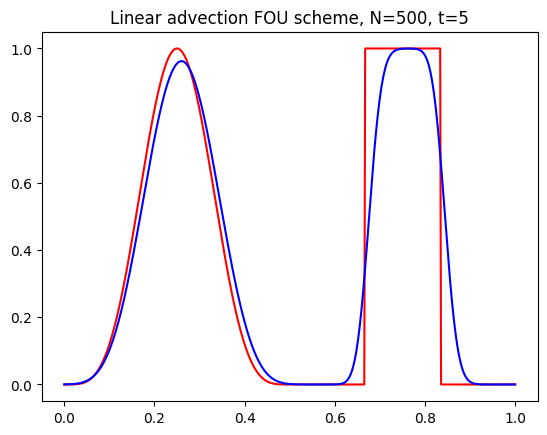

In [22]:
'''Main Program'''
# set up the grid and the initial conditions
dx,x = GridGen(N)
u = InitialConditions(x)
u0 = u.copy()

# call the solver
tOut=5
u, scheme = OneDSolver(tOut, u, dx, FOU)

# Plot the results
fig = plt.figure()
plt.plot(x,u0,'-r')
if (N>120):
    plt.plot(x,u,'-b')
else:
    plt.plot(x,u,'ob')
plt.title('Linear advection {} scheme, N={}, t={}'.format(scheme,N,tOut))
plt.show()

Use the solver to explore what happens if the solution is evolved for 0.5, 1.0, 10.0 and 50.0 seconds on a grid with $N=500$ points. Briefly comment on what you observe.


In [ ]:
%run scripts/show_solutions.py W08_ex1_parte

## Exercise 2
Implement the Lax-Friedrichs scheme, 

$$u^{n+1}_i = \frac{u^n_{i+1}+u^n_{i-1}}{2} - \frac{a\Delta t}{2\Delta x}\left(u^n_{i+1}-u^n_{i-1}\right).$$ 

You are reminded that the <code>np.roll()</code> function should be used to obtain the values of $u^n_{i-1}$ and $u^n_{i+1}$. Remember that the advection speed, $a$, is given by the Python constant <code>AdvectionSpeed</code>.  You should complete the following Python template

In [ ]:
def LaxFriedrichs(u,dx,dt):
    '''Classical Lax-Friedrichs scheme'''

    return u, 'Lax-Friedrichs'

Calculate the solution at 1.0, 10.0 and 50.0 seconds on a grid with $N=500$ points. Briefly comment on what you observe.

In [ ]:
%run scripts/show_solutions.py W08_ex2_parta

Calculate the solution at 1.0 on a grid with $N=50$ points. What do you observe?

In [ ]:
%run scripts/show_solutions.py W08_ex2_partb

## Exercise 3
Implement the Lax-Wendroff scheme, 

$$u^{n+1}_i = u^n_i-\frac{a\Delta t}{2\Delta x}\left(u^n_{i+1}+u^n_{i-1}\right)
 - \frac{a^2\Delta t^2}{2\Delta x^2}\left(u^n_{i+1}-2u^n_i+u^n_{i-1}\right)$$ 

You are reminded that the <code>np.roll()</code> function should be used to obtain the values of $u^n_{i-1}$ and $u^n_{i+1}$. Remember that the advection speed, $a$, is given by the Python constant <code>AdvectionSpeed</code>.  You should complete the following Python template

In [ ]:
def LaxWendroff(u,dx,dt):
    '''Classical, 2nd order, Lax-Wendroff scheme'''
      
    return u, 'Lax-Wendroff'

Calculate the solution at 1.0, 10.0 and 50.0 seconds on a grid with $N=500$ points. Briefly comment on what you observe.

In [ ]:
%run scripts/show_solutions.py W08_ex3_parta

## Exercise 4
Implement the MacCormack predictor-correctorscheme, 

$$\begin{align*}
u^p_i &= u ^n_i - \frac{a\Delta t}{\Delta x}\left(u^n_i - u^n_{i-1}\right) \\
u^{n+1}_i &= \frac{u^p_i+u^n_i}{2} - \frac{a\Delta t}{2\Delta x}\left(u^p_{i+1} - u^p_i\right)
\end{align*}
$$ 

You are reminded that the <code>np.roll()</code> function should be used to obtain the values of $u^n_{i-1}$ and $u^n_{i+1}$. Remember that the advection speed, $a$, is given by the Python constant <code>AdvectionSpeed</code>.  You should complete the following Python template

In [ ]:
def MacCormack(u,dx,dt):
    '''2nd order MacCormack predictor corrector method which is
    equivalent to the classical Lax-Wendroff scheme.'''

    # Predictor
    up = 
    # Corrector
    u =
    
    return u, 'MacCormack'    

Check that the solution at 10.0 seconds on a grid with $N=500$ points is equivalent to the solution obtained with the Lax-Wendroff Scheme.

In [ ]:
%run scripts/show_solutions.py W08_ex4_parta

In [ ]:
### Part b)

Using either the MacCormack or the Lax-Wendroff scheme see what happens when $a=-1$, 
compare the solution at $t=10.0$ seconds with the case where $a=1$


In [ ]:
%run scripts/show_solutions.py W08_ex4_partb